In [37]:
import rasterio
from pyproj import Transformer

# 指定 TIF 文件路径
# tif_file = '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2024_japan2/building_footprint/2024_japan2_building_footprint_rasterized.tif'
tif_file = '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/prior_models/2023_turkey_prior_landslide_model.tif'
# '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/prior_models/2023_turkey_prior_landslide_model.tif'
# 打开 TIF 文件
with rasterio.open(tif_file) as dataset:
    # 获取 TIF 文件的边界 (left, bottom, right, top)
    bbox = dataset.bounds
    
    # 如果 CRS 是投影坐标系，需要进行转换为经纬度
    if dataset.crs != 'EPSG:4326':
        transformer = Transformer.from_crs(dataset.crs, 'EPSG:4326', always_xy=True)
        min_lon, min_lat = transformer.transform(bbox.left, bbox.bottom)
        max_lon, max_lat = transformer.transform(bbox.right, bbox.top)
    else:
        min_lon, min_lat, max_lon, max_lat = bbox.left, bbox.bottom, bbox.right, bbox.top

# 打印经纬度范围
print(f"Bounding box in lat/lon: ({min_lat}, {min_lon}, {max_lat}, {max_lon})")

Bounding box in lat/lon: (35.67392313489886, 35.73200043157658, 37.15253424616296, 37.06977820948336)


In [38]:
import osmnx as ox
import geopandas as gpd
# Bounding box in lat/lon: (35.67392313489886, 35.73200043157658, 37.24253424617227, 37.06977820948336)
# 定义边界框
# bbox_coords = (37.4133, 37.3747, 136.9408, 136.7703)  # (south, west, north, east)
# bbox_coords = (35.6739, 35.7320, 37.1525, 37.0698)  # (south, west, north, east)
bbox_coords = (35.6739, 35.7320, 37.1525, 37.0698)  # (south, west, north, east)
# 下载建筑物数据
footprints = ox.geometries.geometries_from_bbox(*bbox_coords, tags={'building': True})

# 保存为 GeoJSON 格式（可选）
# footprints.to_file('/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/building_footprint/os_2023_turkey_footprints.geojson', driver='GeoJSON')

shp_output_path = '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/building_footprint/shp_2023_turkey_footprints.shp'
footprints.to_file(shp_output_path, driver='ESRI Shapefile')

/var/folders/hx/j8zrcsfx0cv0hwpd327473r40000gn/T/ipykernel_44045/2109824384.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  footprints = ox.geometries.geometries_from_bbox(*bbox_coords, tags={'building': True})
/Users/lixintong/opt/anaconda3/envs/three_env/lib/python3.9/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/Users/lixintong/opt/anaconda3/envs/three_env/lib/python3.9/site-packages/

In [31]:
from rasterio.features import rasterize
import numpy as np

# 获取建筑物几何
shapes = [(geom, 1) for geom in footprints.geometry]

# 定义栅格化参数
output_shape = (dataset.height, dataset.width)  # 和 TIF 文件一致
transform = dataset.transform

# 栅格化
raster = rasterize(
    shapes,
    out_shape=output_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

# 保存为栅格文件
output_tif = '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/building_footprint/os2_2023_turkey_footprints.tif'
with rasterio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype='uint8',
    crs=dataset.crs,
    transform=transform
) as dst:
    dst.write(raster, 1)

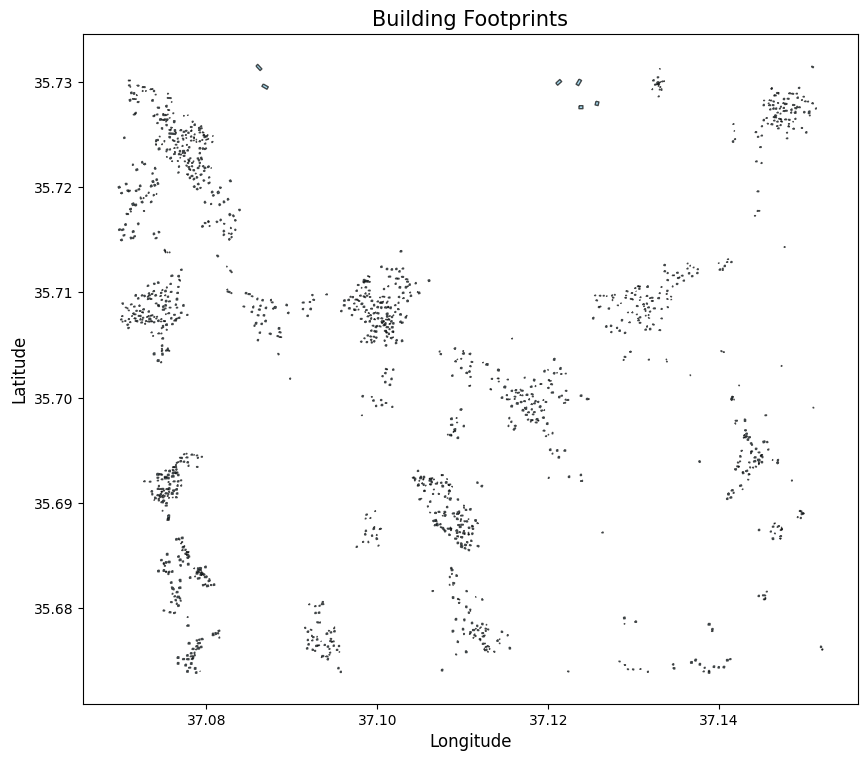

In [33]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 加载刚保存的建筑物 GeoJSON 文件
geojson_path = '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/building_footprint/os_2023_turkey_footprints.geojson'
footprints = gpd.read_file(geojson_path)

# 设置图形尺寸
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制建筑物数据
footprints.plot(ax=ax, color="skyblue", edgecolor="black", alpha=0.7)

# 设置标题和标签
ax.set_title("Building Footprints", fontsize=15)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# 显示图例（可选）
plt.show()

In [34]:
print("Transform:", dataset.transform)
print("Output shape:", output_shape)
print("Footprints CRS:", footprints.crs)
print("Dataset CRS:", dataset.crs)

Transform: | 0.00, 0.00, 35.73|
| 0.00,-0.00, 37.15|
| 0.00, 0.00, 1.00|
Output shape: (5323, 4816)
Footprints CRS: EPSG:4326
Dataset CRS: EPSG:4326


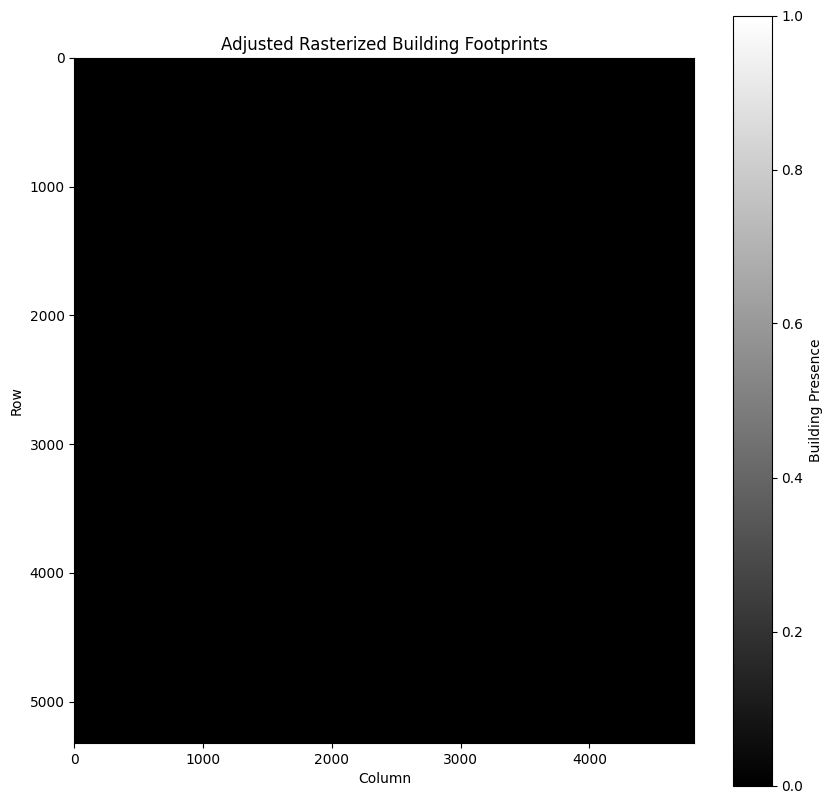

In [35]:
# 可视化栅格数据
plt.figure(figsize=(10, 10))
plt.imshow(raster, cmap='gray', origin='upper')
plt.colorbar(label="Building Presence")
plt.title("Adjusted Rasterized Building Footprints")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


Raster unique values: [0 1]


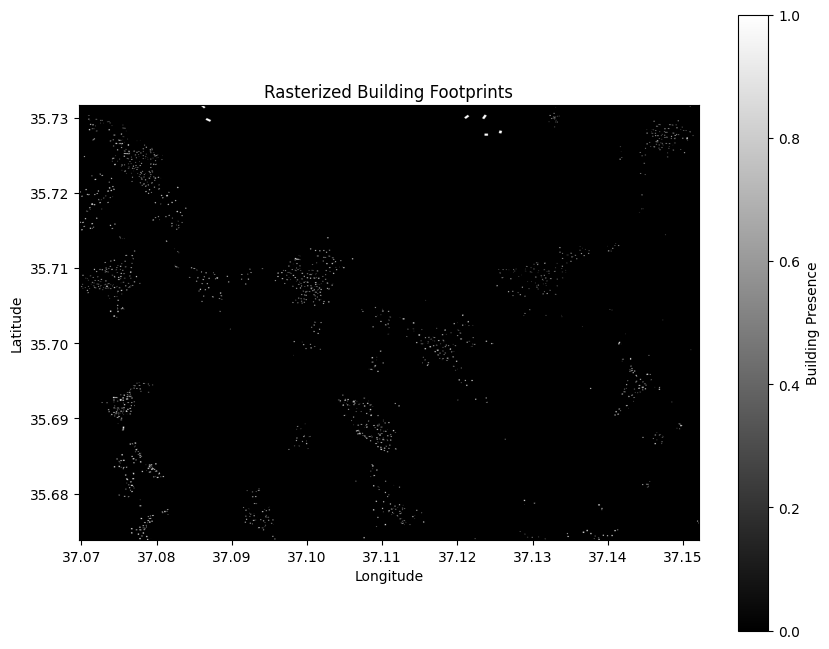

In [36]:
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
import matplotlib.pyplot as plt

# 检查和调整 CRS
if footprints.crs != dataset.crs:
    footprints = footprints.to_crs(dataset.crs)

# 获取建筑物几何及属性值
shapes = [(geom, 1) for geom in footprints.geometry]  # 属性值为 1，代表建筑物

# 动态计算栅格化参数
bounds = footprints.total_bounds  # [minx, miny, maxx, maxy]
output_shape = (dataset.height, dataset.width)  # 可根据需求调整
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], output_shape[1], output_shape[0])

# 栅格化
raster = rasterize(
    shapes,
    out_shape=output_shape,
    transform=transform,
    fill=0,  # 非建筑物区域为 0
    all_touched=False,  # 仅覆盖建筑物实际像素
    dtype='uint8'
)

# 检查栅格值分布
unique_values = np.unique(raster)
print(f"Raster unique values: {unique_values}")

# 保存为栅格文件
output_tif = '/Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/building_footprint/os_2023_turkey_footprints.tif'
with rasterio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype='uint8',
    crs=dataset.crs,
    transform=transform
) as dst:
    dst.write(raster, 1)

# 可视化栅格化结果
plt.figure(figsize=(10, 8))
plt.title("Rasterized Building Footprints")
plt.imshow(raster, cmap='gray', extent=(bounds[0], bounds[2], bounds[1], bounds[3]))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Building Presence")
plt.show()

Reprojected raster saved to: /Users/lixintong/Desktop/大三上/大数据并行计算/并行大作业/第三次作业/Bayesian_Causal-main/data/2023_turkey_new/building_footprint/os_2023_turkey_footprints_gcs.tif
